In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sqlite3
from scipy.stats import ttest_ind
import scipy.stats as stats
warnings.filterwarnings('ignore')

## Loading Dataset

In [2]:
#Creating database connection
conn = sqlite3.connect('inventory.db')

#Fetching vendor summary data
df = pd.read_sql_query("SELECT * FROM vendor_sales_summary", conn)
df.head()

,VendorNumber,VendorName,Brand,Description,PurchasePrice,Volume,ActualPrice,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnover,Sales_To_Purchase_Ratio
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,1750.0,36.99,145080,3811251.60,142049.0,5101919.51,672819.31,260999.20,68601.68,1290667.91,25.297693,0.979108,1.338647
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,23.19,1750.0,28.99,164038,3804041.22,160247.0,4819073.49,561512.37,294438.66,144929.24,1015032.27,21.062810,0.976890,1.266830
2,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,18.24,1750.0,24.99,187407,3418303.68,187140.0,4538120.60,461140.15,343854.07,123780.22,1119816.92,24.675786,0.998575,1.327594
3,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,16.17,1750.0,22.99,201682,3261197.94,200412.0,4475972.88,420050.01,368242.80,257032.07,1214774.94,27.139908,0.993703,1.372493
4,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,21.89,1750.0,29.99,138109,3023206.01,135838.0,4223107.62,545778.28,249587.83,257032.07,1199901.61,28.412764,0.983556,1.396897


### 🔍 Exploratory Data Analysis

* I previously explored the various tables in the database to identify key variables, understand their relationships, and decide which ones to include in my final analysis.

* In this phase of EDA, I’ll analyze the resulting table to examine the distribution of each column. This will help me uncover patterns, spot anomalies, and ensure data quality before moving forward.

In [3]:
# Summary Statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
VendorNumber,10692.0,10650.649458,18753.519148,2.00,3951.000000,7153.000000,9552.000000,2.013590e+05
Brand,10692.0,18039.228769,12662.187074,58.00,5793.500000,18761.500000,25514.250000,9.063100e+04
PurchasePrice,10692.0,24.385303,109.269375,0.36,6.840000,10.455000,19.482500,5.681810e+03
Volume,10692.0,847.360550,664.309212,50.00,750.000000,750.000000,750.000000,2.000000e+04
ActualPrice,10692.0,35.643671,148.246016,0.49,10.990000,15.990000,28.990000,7.499990e+03
TotalPurchaseQuantity,10692.0,3140.886831,11095.086769,1.00,36.000000,262.000000,1975.750000,3.376600e+05
TotalPurchaseDollars,10692.0,30106.693372,123067.799627,0.71,453.457500,3655.465000,20738.245000,3.811252e+06
TotalSalesQuantity,10692.0,3077.482136,10952.851391,0.00,33.000000,261.000000,1929.250000,3.349390e+05
TotalSalesDollars,10692.0,42239.074419,167655.265984,0.00,729.220000,5298.045000,28396.915000,5.101920e+06
TotalSalesPrice,10692.0,18793.783627,44952.773386,0.00,289.710000,2857.800000,16059.562500,6.728193e+05


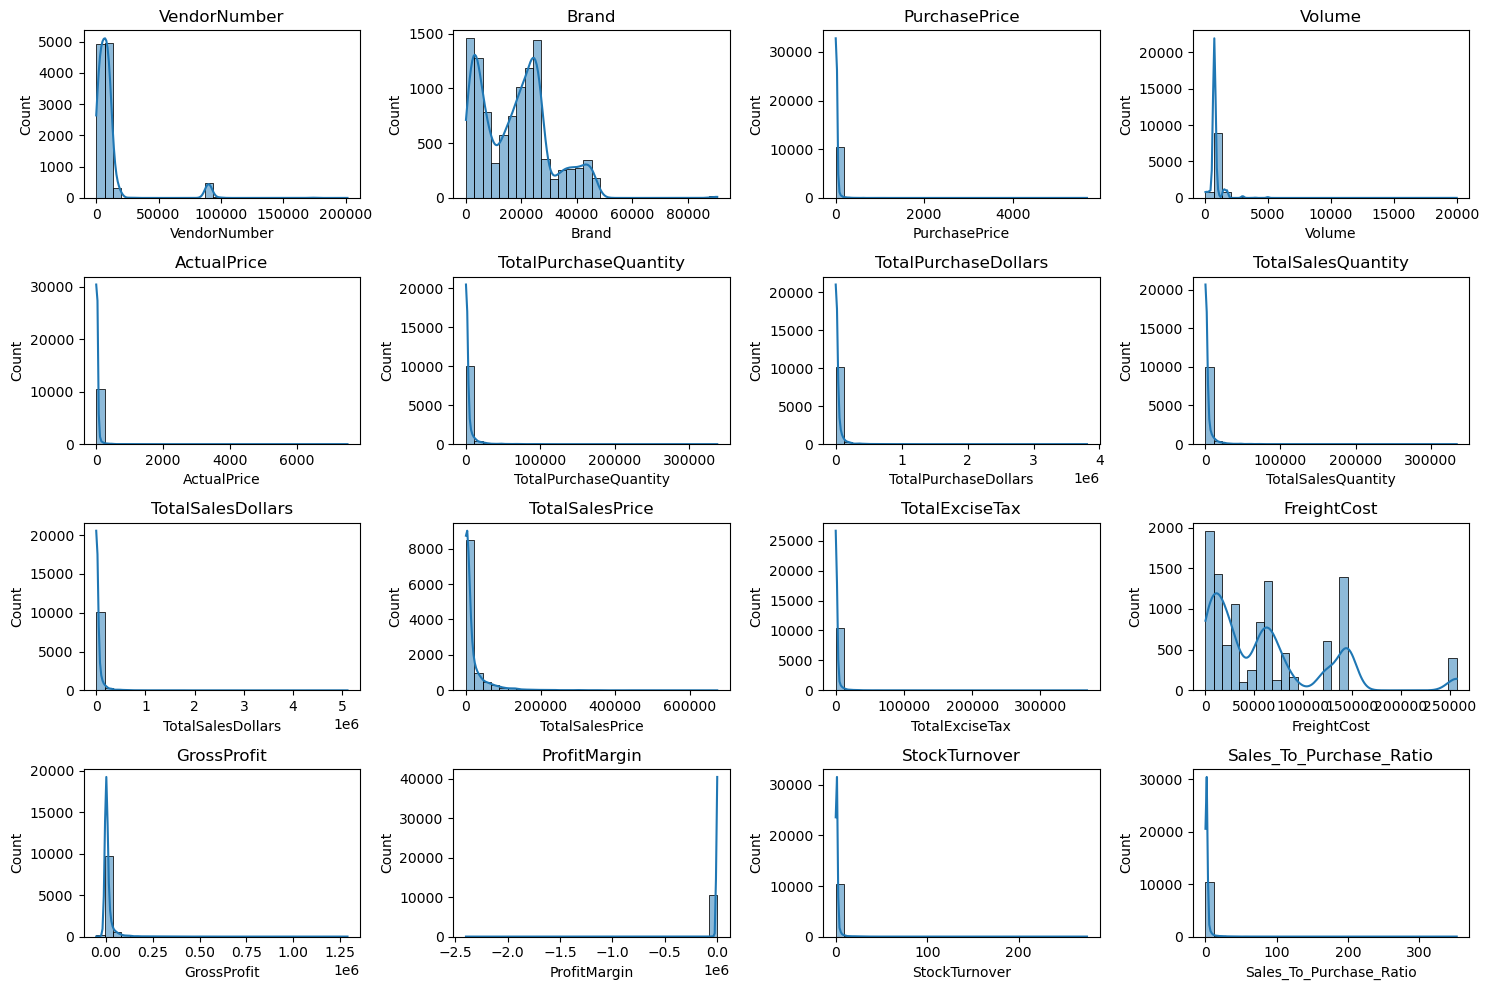

In [4]:
# Distribution Plots for Numerical Columns

num_cols = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(15,10))
for i, col in enumerate(num_cols):
    plt.subplot(4,4,i+1)  #Adjust grid layput as per need
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

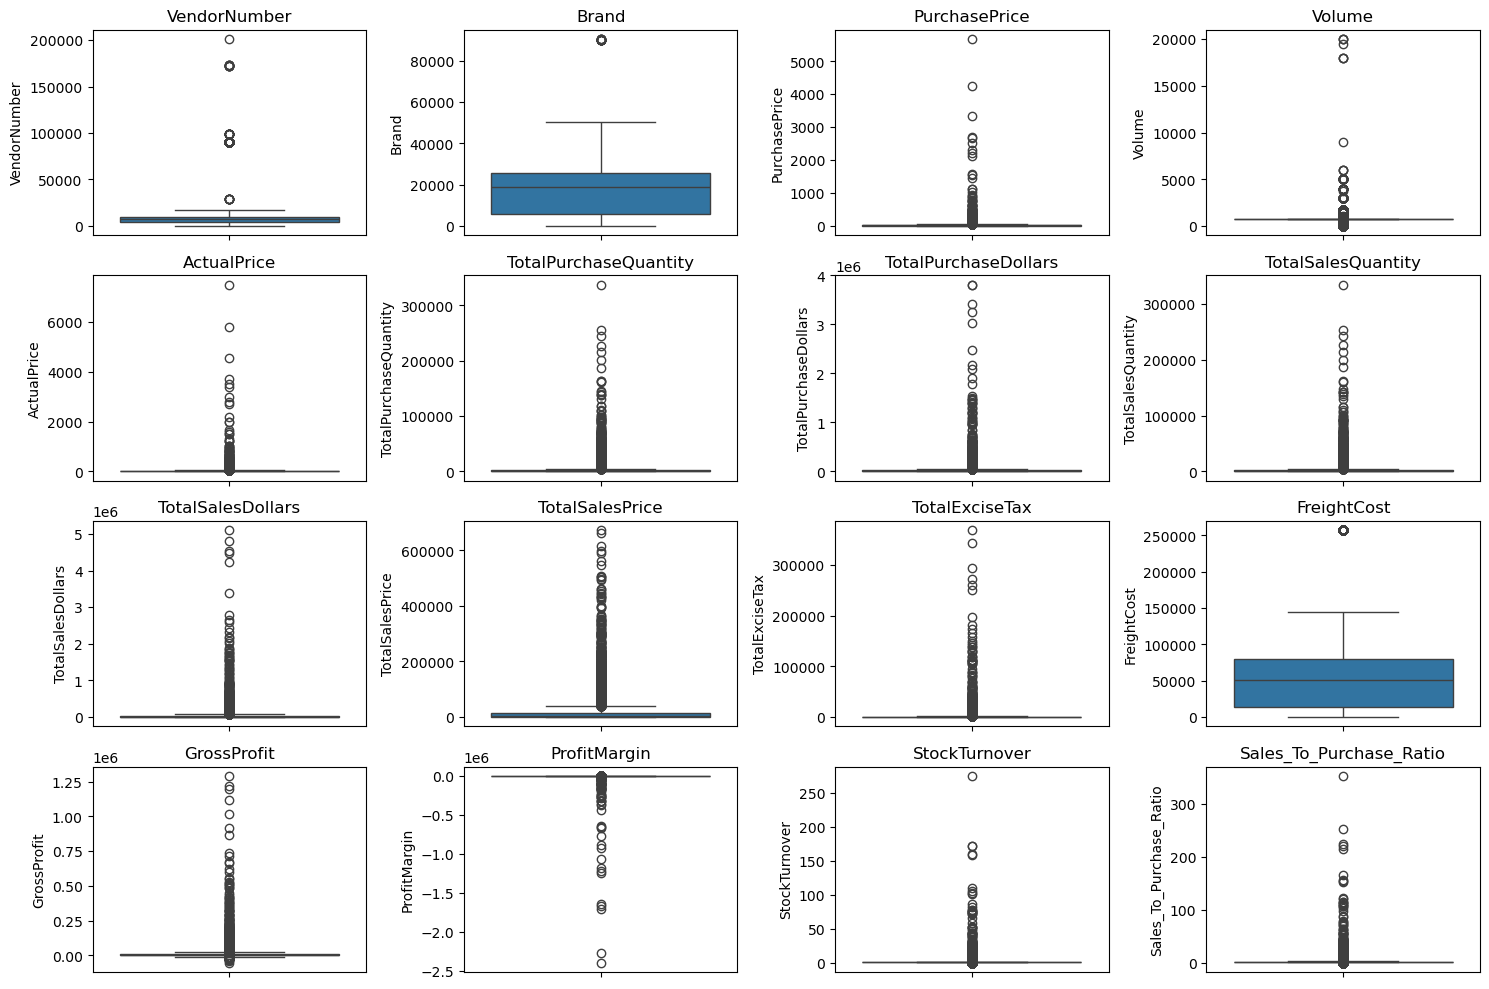

In [5]:
# Outlier Detection using Boxplot

plt.figure(figsize=(15,10))
for i, col in enumerate(num_cols):
    plt.subplot(4,4,i+1)  #Adjust grid layput as per need
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

### 📊 Summary Statistics Insights

#### 🔴 **Negative & Zero Values**

* **Gross Profit**: Minimum value of `-52,002.78` indicates certain transactions resulted in a loss — likely due to high costs or discounted selling prices below purchase prices.
* **Profit Margin**: A minimum of `-∞` suggests revenue is zero or even negative in some cases, which could happen if no sales occurred but purchases did.
* **Sales Quantity & Sales Dollars**: Minimum values of `0` highlight products that were purchased but never sold — potentially slow-moving or obsolete inventory.

#### ⚠️ **Outliers (High Standard Deviation)**

* **Purchase Price & Actual Price**: Maximum values (`5,681.81` and `7,499.99`) are far above the mean (`24.39` and `35.64`), indicating the presence of premium or niche products.
* **Freight Cost**: Ranges from `0.09` to `257,032.07`, reflecting large variance possibly due to logistics inefficiencies or massive shipments.
* **Stock Turnover**: Ranges from `0` to `274.5`. High values suggest products that sell rapidly, while zero implies stagnant stock. A value >1 indicates sales exceeded recent purchases, likely fulfilled using existing inventory.

In [6]:
# Filtering the data by removing inconsistencies
df = pd.read_sql_query("""
        SELECT * 
        FROM vendor_sales_summary
        WHERE GrossProfit > 0 AND ProfitMargin > 0
        AND TotalSalesQuantity > 0
""", conn)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8564 entries, 0 to 8563
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   VendorNumber             8564 non-null   int64  
 1   VendorName               8564 non-null   object 
 2   Brand                    8564 non-null   int64  
 3   Description              8564 non-null   object 
 4   PurchasePrice            8564 non-null   float64
 5   Volume                   8564 non-null   float64
 6   ActualPrice              8564 non-null   float64
 7   TotalPurchaseQuantity    8564 non-null   int64  
 8   TotalPurchaseDollars     8564 non-null   float64
 9   TotalSalesQuantity       8564 non-null   float64
 10  TotalSalesDollars        8564 non-null   float64
 11  TotalSalesPrice          8564 non-null   float64
 12  TotalExciseTax           8564 non-null   float64
 13  FreightCost              8564 non-null   float64
 14  GrossProfit             

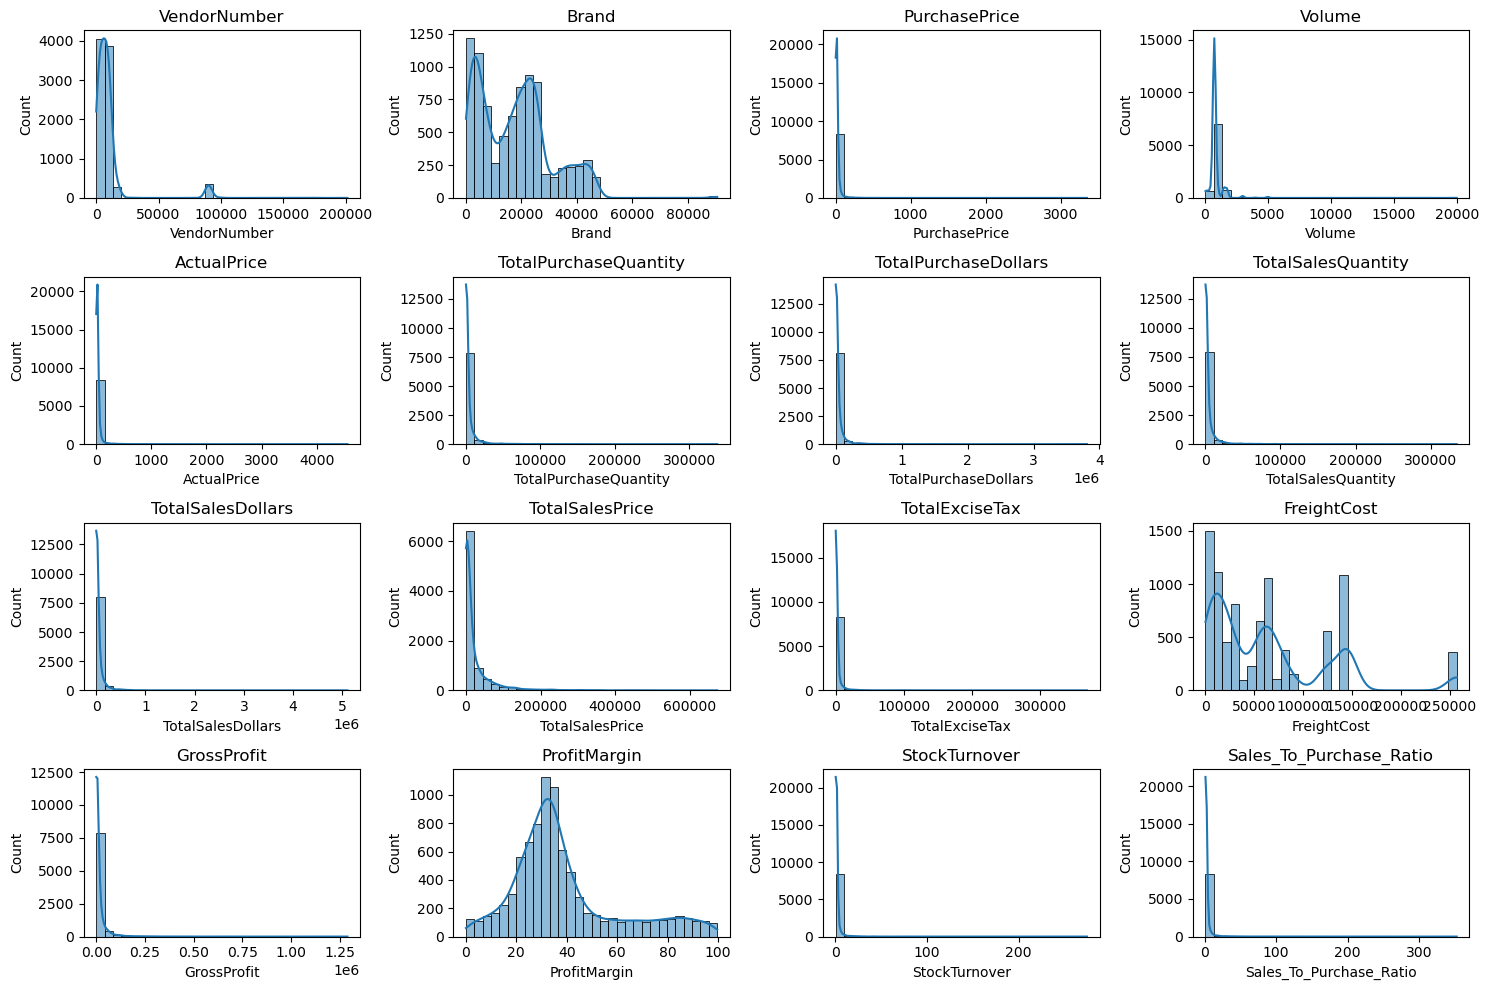

In [7]:
num_cols = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(15,10))
for i, col in enumerate(num_cols):
    plt.subplot(4,4,i+1)  #Adjust grid layput as per need
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

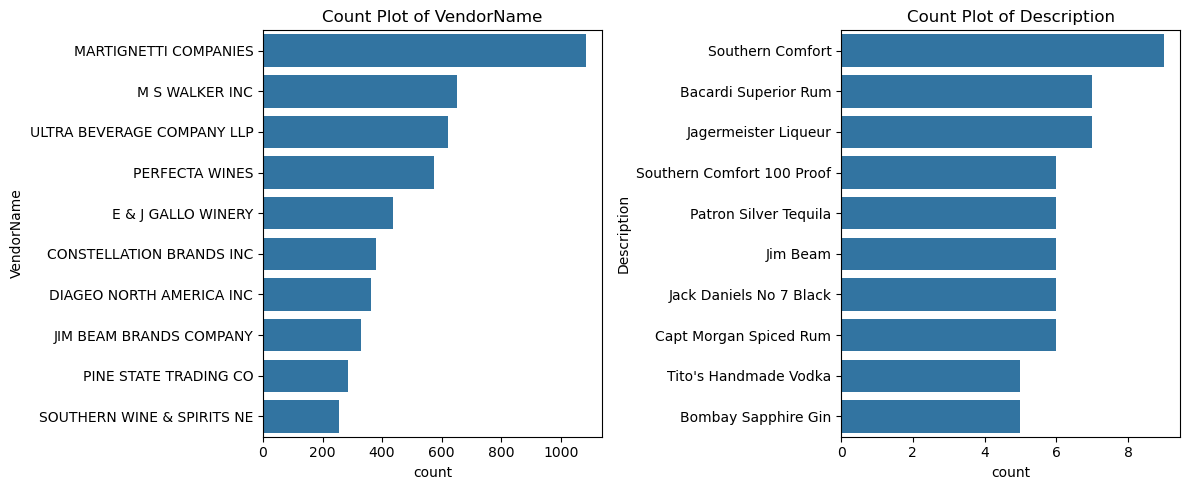

In [8]:
# Count Plots for Categorical Columns
cat_cols = ["VendorName", "Description"]

plt.figure(figsize=(12,5))
for i, col in enumerate(cat_cols):
    plt.subplot(1, 2, i+1)
    sns.countplot(y=df[col], order=df[col].value_counts().index[:10])  # Top 10 Categories
    plt.title(f"Count Plot of {col}")
plt.tight_layout()
plt.show()

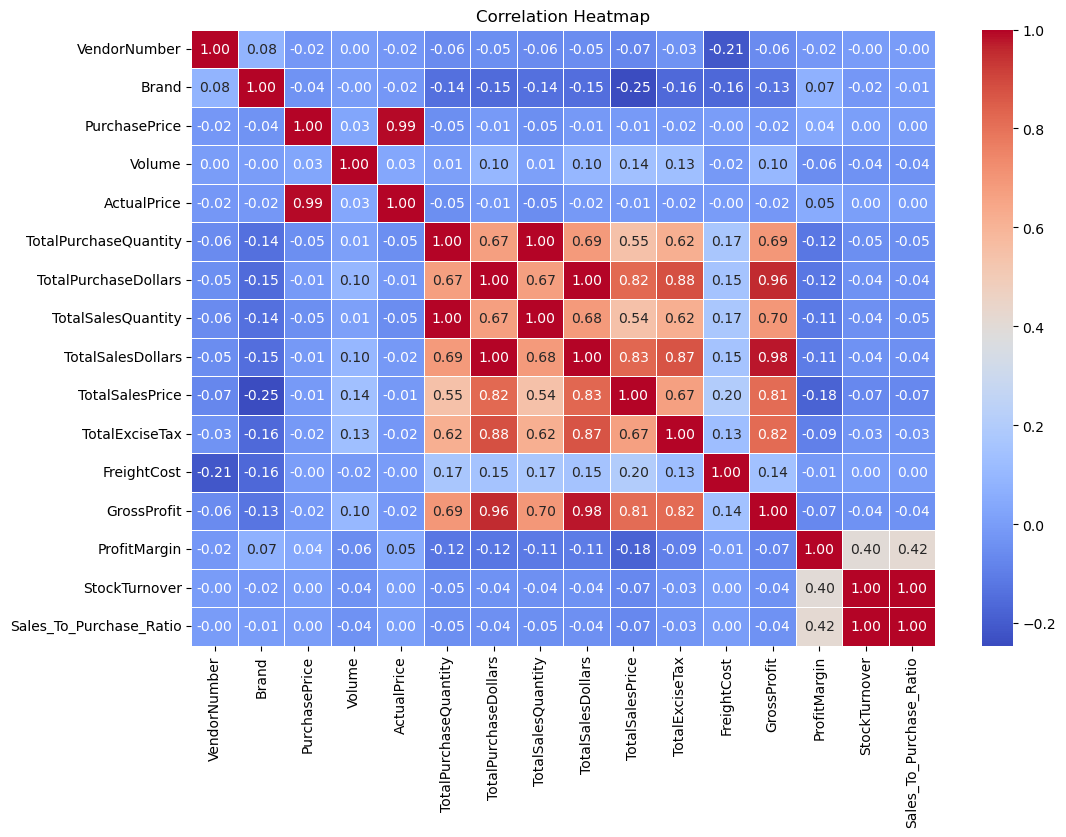

In [9]:
# Correlation Heatmap

plt.figure(figsize=(12,8))
correlation_matrix = df[num_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

### 🔗 Correlation Insights

* **Purchase Price** shows **very weak correlation** with:

  * **Total Sales Dollars**: `-0.012`
  * **Gross Profit**: `-0.016`
    ➤ This suggests that changes in purchase price have little to no direct impact on sales revenue or profit.

* **Total Purchase Quantity vs. Total Sales Quantity**:
  ➤ **Strong positive correlation (`0.999`)**, indicating efficient inventory movement — what’s purchased is largely being sold.

* **Profit Margin vs. Total Sales Price**:
  ➤ **Moderate negative correlation (`-0.179`)**, suggesting that as sales prices rise, profit margins tend to decrease — possibly due to discounts or competitive pricing pressure.

* **Stock Turnover** correlations:

  * With **Gross Profit**: `-0.038` (weak negative)
  * With **Profit Margin**: `-0.055` (weak negative)
    ➤ Indicates that faster-selling products do not necessarily contribute more to overall profitability.

## 📈 Data Analysis

Identify brands with **low sales performance** but **high profit margins**, as they may benefit from **promotional efforts** or **pricing adjustments** to boost volume while preserving profitability.


In [10]:
brand_performance = df.groupby('Description').agg({
    "TotalSalesDollars": 'sum',
    "ProfitMargin": "mean"
}).reset_index()

In [11]:
low_sales_thresold = brand_performance["TotalSalesDollars"].quantile(0.15)
high_margin_thresold = brand_performance["ProfitMargin"].quantile(0.85)

In [12]:
low_sales_thresold

560.299

In [13]:
high_margin_thresold

64.97017552750113

In [14]:
#filter brands with low sales but high profit margins
target_brands = brand_performance[
    (brand_performance['TotalSalesDollars'] <= low_sales_thresold) &
    (brand_performance['ProfitMargin'] >= high_margin_thresold)
]
print("Brands with Low Sales but High Profit Margins:")
display(target_brands.sort_values('TotalSalesDollars'))

Brands with Low Sales but High Profit Margins:


,Description,TotalSalesDollars,ProfitMargin
6199,Santa Rita Organic Svgn Bl,9.99,66.466466
2369,Debauchery Pnt Nr,11.58,65.975820
2070,Concannon Glen Ellen Wh Zin,15.95,83.448276
2188,Crown Royal Apple,27.86,89.806174
6237,Sauza Sprklg Wild Berry Marg,27.96,82.153076
...,...,...,...
5074,Nanbu Bijin Southern Beauty,535.68,76.747312
2271,Dad's Hat Rye Whiskey,538.89,81.851584
57,A Bichot Clos Marechaudes,539.94,67.740860
6245,Sbragia Home Ranch Merlot,549.75,66.444748


In [15]:
brand_performance = brand_performance[brand_performance['TotalSalesDollars']<10000] # For better visualization

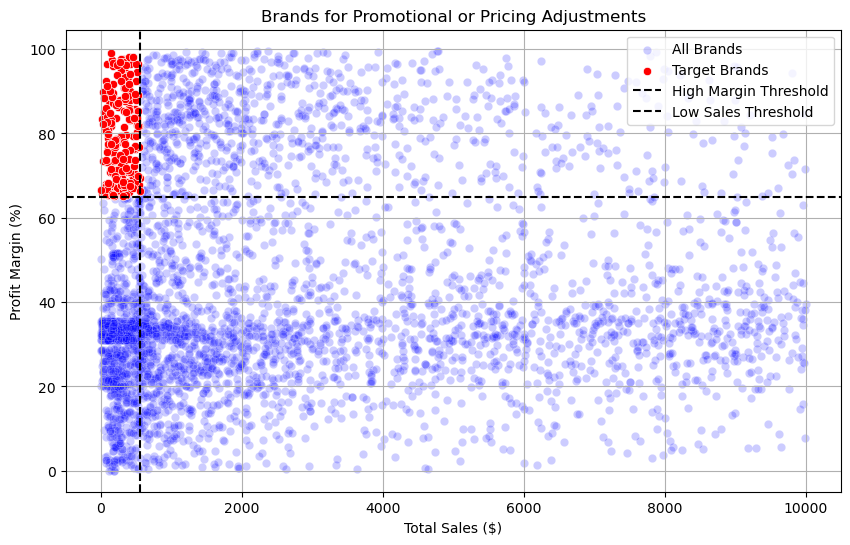

In [16]:
# Scatter Plot

plt.figure(figsize=(10,6))
sns.scatterplot(data=brand_performance, x='TotalSalesDollars', y='ProfitMargin', color='blue', label='All Brands', alpha=0.2)
sns.scatterplot(data=target_brands, x='TotalSalesDollars', y='ProfitMargin', color='red', label='Target Brands')

plt.axhline(high_margin_thresold, linestyle='--', color='black', label='High Margin Threshold')
plt.axvline(low_sales_thresold, linestyle='--', color='black', label='Low Sales Threshold')

plt.xlabel("Total Sales ($)")
plt.ylabel("Profit Margin (%)")
plt.title("Brands for Promotional or Pricing Adjustments")
plt.legend()
plt.grid(True)
plt.show()

### Business Questions

1. Which vendors and brands demonstrate the highest sales performance?**

In [17]:
def format_dollars(value):
    if value >= 1_000_000:
        return f"{value/1_000_000:.2f}M"
    elif value >= 1_000:
        return f"{value/1_000:.2f}K"
    else:
        return str(value)

In [18]:
# Top Vendors and Brands by Sales Performance
top_vendors = df.groupby('VendorName')['TotalSalesDollars'].sum().nlargest(10)
top_brands = df.groupby('Description')['TotalSalesDollars'].sum().nlargest(10)

top_vendors.apply(lambda x: format_dollars(x))

VendorName
DIAGEO NORTH AMERICA INC      67.99M
MARTIGNETTI COMPANIES         39.33M
PERNOD RICARD USA             32.06M
JIM BEAM BRANDS COMPANY       31.42M
BACARDI USA INC               24.85M
CONSTELLATION BRANDS INC      24.22M
E & J GALLO WINERY            18.40M
BROWN-FORMAN CORP             18.25M
ULTRA BEVERAGE COMPANY LLP    16.50M
M S WALKER INC                14.71M
Name: TotalSalesDollars, dtype: object

In [19]:
top_brands.apply(lambda x: format_dollars(x))

Description
Jack Daniels No 7 Black    7.96M
Tito's Handmade Vodka      7.40M
Grey Goose Vodka           7.21M
Capt Morgan Spiced Rum     6.36M
Absolut 80 Proof           6.24M
Jameson Irish Whiskey      5.72M
Ketel One Vodka            5.07M
Baileys Irish Cream        4.15M
Kahlua                     3.60M
Tanqueray                  3.46M
Name: TotalSalesDollars, dtype: object

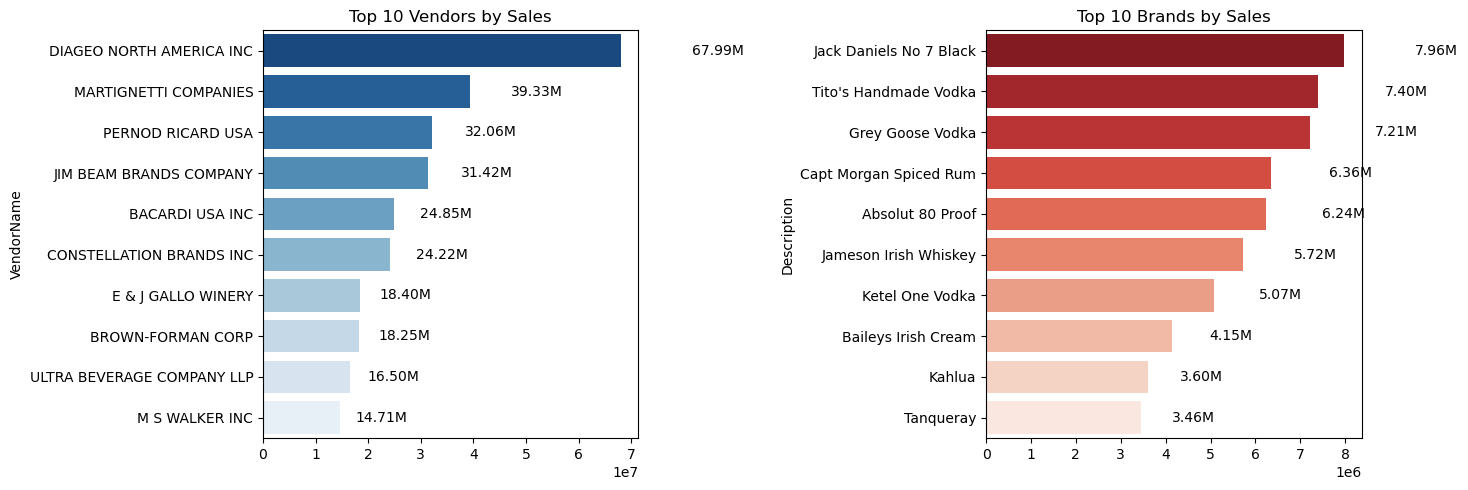

In [20]:
plt.figure(figsize=(15, 5))

# Plot for Top Vendors
plt.subplot(1,2,1)
ax1 = sns.barplot(y=top_vendors.index, x=top_vendors.values, palette="Blues_r")
plt.title("Top 10 Vendors by Sales")

for bar in ax1.patches:
    ax1.text(bar.get_width() + (bar.get_width() * 0.2),
            bar.get_y() + bar.get_height() / 2,
            format_dollars(bar.get_width()),
            ha='left', va='center', fontsize=10, color='black')

# Plot for Top Brands
plt.subplot(1,2,2)
ax2 = sns.barplot(y=top_brands.index, x=top_brands.values, palette="Reds_r")
plt.title("Top 10 Brands by Sales")

for bar in ax2.patches:
    ax2.text(bar.get_width() + (bar.get_width() * 0.2),
            bar.get_y() + bar.get_height() / 2,
            format_dollars(bar.get_width()),
            ha='left', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

**2. Which Vendors contribute the most to total purchase dollars?**

In [21]:
vendor_performance = df.groupby('VendorName').agg({
        'TotalPurchaseDollars': 'sum',
        'GrossProfit': 'sum',
        'TotalSalesDollars': 'sum'
    }).reset_index()

vendor_performance

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars
0,ADAMBA IMPORTS INTL INC,446.16,258.37,704.53
1,ALISA CARR BEVERAGES,25698.12,78772.82,104470.94
2,ALTAMAR BRANDS LLC,11706.20,4000.61,15706.81
3,AMERICAN SPIRITS EXCHANGE,934.08,577.08,1511.16
4,AMERICAN VINTAGE BEVERAGE,104435.68,35167.85,139603.53
...,...,...,...,...
114,WEIN BAUER INC,42694.64,13522.49,56217.13
115,WESTERN SPIRITS BEVERAGE CO,298416.86,106837.97,405254.83
116,WILLIAM GRANT & SONS INC,5876538.26,1693337.94,7569876.20
117,WINE GROUP INC,5203801.17,3100242.11,8304043.28


In [22]:
vendor_performance['PurchaseContribution%'] = vendor_performance['TotalPurchaseDollars']/vendor_performance['TotalPurchaseDollars'].sum()*100

In [23]:
vendor_performance = round(vendor_performance.sort_values("PurchaseContribution%", ascending=False),2)

In [24]:
#Display Top 10 Vendors
top_vendors = vendor_performance.head(10)
top_vendors['TotalSalesDollars'] = top_vendors['TotalSalesDollars'].apply(format_dollars)
top_vendors['TotalPurchaseDollars'] = top_vendors['TotalPurchaseDollars'].apply(format_dollars)
top_vendors['GrossProfit'] = top_vendors['GrossProfit'].apply(format_dollars)

top_vendors

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseContribution%
25,DIAGEO NORTH AMERICA INC,50.10M,17.89M,67.99M,16.30
57,MARTIGNETTI COMPANIES,25.50M,13.83M,39.33M,8.30
68,PERNOD RICARD USA,23.85M,8.21M,32.06M,7.76
46,JIM BEAM BRANDS COMPANY,23.49M,7.93M,31.42M,7.64
6,BACARDI USA INC,17.43M,7.42M,24.85M,5.67
20,CONSTELLATION BRANDS INC,15.27M,8.95M,24.22M,4.97
11,BROWN-FORMAN CORP,13.24M,5.01M,18.25M,4.31
30,E & J GALLO WINERY,12.07M,6.33M,18.40M,3.93
106,ULTRA BEVERAGE COMPANY LLP,11.17M,5.34M,16.50M,3.63
53,M S WALKER INC,9.76M,4.94M,14.71M,3.18


In [25]:
top_vendors["Cumulative_Contribution%"] = top_vendors['PurchaseContribution%'].cumsum()
top_vendors

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseContribution%,Cumulative_Contribution%
25,DIAGEO NORTH AMERICA INC,50.10M,17.89M,67.99M,16.30,16.30
57,MARTIGNETTI COMPANIES,25.50M,13.83M,39.33M,8.30,24.60
68,PERNOD RICARD USA,23.85M,8.21M,32.06M,7.76,32.36
46,JIM BEAM BRANDS COMPANY,23.49M,7.93M,31.42M,7.64,40.00
6,BACARDI USA INC,17.43M,7.42M,24.85M,5.67,45.67
20,CONSTELLATION BRANDS INC,15.27M,8.95M,24.22M,4.97,50.64
11,BROWN-FORMAN CORP,13.24M,5.01M,18.25M,4.31,54.95
30,E & J GALLO WINERY,12.07M,6.33M,18.40M,3.93,58.88
106,ULTRA BEVERAGE COMPANY LLP,11.17M,5.34M,16.50M,3.63,62.51
53,M S WALKER INC,9.76M,4.94M,14.71M,3.18,65.69


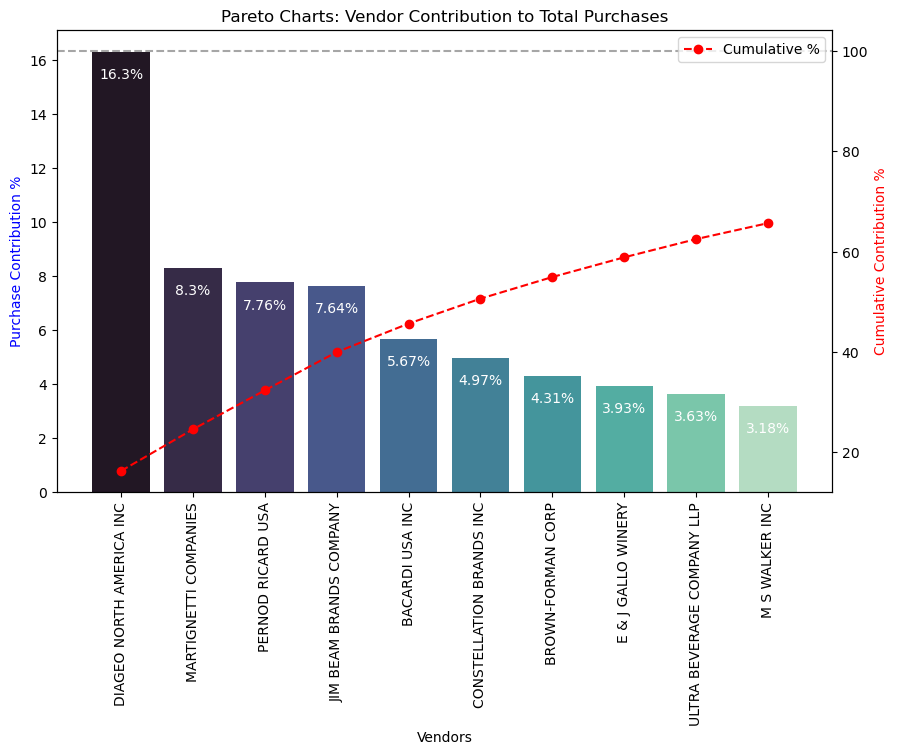

In [26]:
fig, ax1 = plt.subplots(figsize=(10,6))

# Bar plot for Purchase Contribution%
sns.barplot(x=top_vendors['VendorName'], y=top_vendors['PurchaseContribution%'], palette="mako", ax=ax1)

for i, value in enumerate(top_vendors['PurchaseContribution%']):
    ax1.text(i, value - 1, str(value)+'%', ha='center', fontsize=10, color='white')

# Line plot for Cumulative Contribution
ax2 = ax1.twinx()
ax2.plot(top_vendors['VendorName'], top_vendors['Cumulative_Contribution%'], color="red", marker='o', linestyle='dashed', label='Cumulative %')

ax1.set_xticklabels(top_vendors['VendorName'], rotation=90)
ax1.set_ylabel('Purchase Contribution %', color="blue")
ax2.set_ylabel('Cumulative Contribution %', color="red")
ax1.set_xlabel('Vendors')
ax1.set_title('Pareto Charts: Vendor Contribution to Total Purchases')

ax2.axhline(y=100, color='gray', linestyle='dashed', alpha=0.7)
ax2.legend(loc='upper right')

plt.show()

**3. How much of total procurement is dependent on the top vendors?**

In [27]:
print(f"Total Purchase Contribution of the Top 10 Vendors is {round(top_vendors['PurchaseContribution%'].sum(),2)}%.")

Total Purchase Contribution of the Top 10 Vendors is 65.69%.


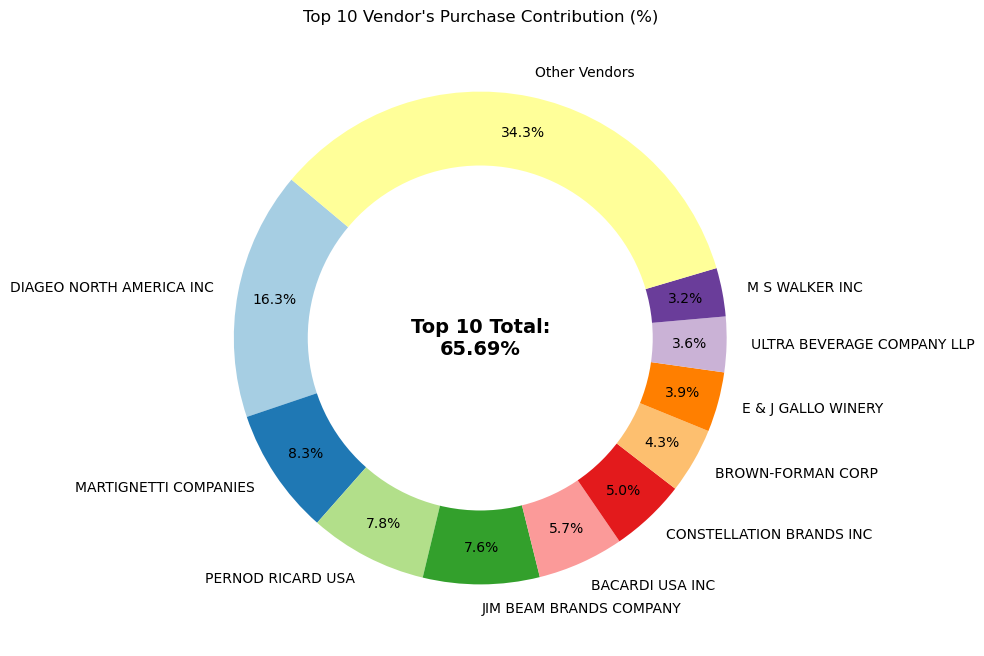

In [28]:
vendors = list(top_vendors['VendorName'].values)
purchase_contribution = list(top_vendors['PurchaseContribution%'].values)
total_contribution = sum(purchase_contribution)
remaining_contribution = 100 - total_contribution

# Append "Other Vendors" Category
vendors.append('Other Vendors')
purchase_contribution.append(remaining_contribution)

# Donut Chart
fig, ax = plt.subplots(figsize=(8,8))
wedges, texts, autotexts = ax.pie(purchase_contribution, labels=vendors, autopct='%1.1f%%',
                                  startangle=140, pctdistance=0.85, colors=plt.cm.Paired.colors)

# Dram a white cicle in the center to create a "Donut" effect
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Add Total Contribution annotation in the center
plt.text(0, 0, f"Top 10 Total:\n{total_contribution:.2f}%", fontsize=14, fontweight='bold', ha='center', va='center')

plt.title("Top 10 Vendor's Purchase Contribution (%)")
plt.show()

**4. Does purchasing in bulk reduce the unit price, and what is the optimal purchase volumne for cost savings?**

In [29]:
df['UnitPurchasePrice'] = df['TotalPurchaseDollars'] / df['TotalPurchaseQuantity']

In [30]:
df['OrderSize'] = pd.qcut(df['TotalPurchaseQuantity'], q=3, labels=['Small', 'Medium', 'Large']) 

In [31]:
df.groupby('OrderSize')[['UnitPurchasePrice']].mean()

,UnitPurchasePrice
OrderSize,
Small,39.068186
Medium,15.486414
Large,10.777625


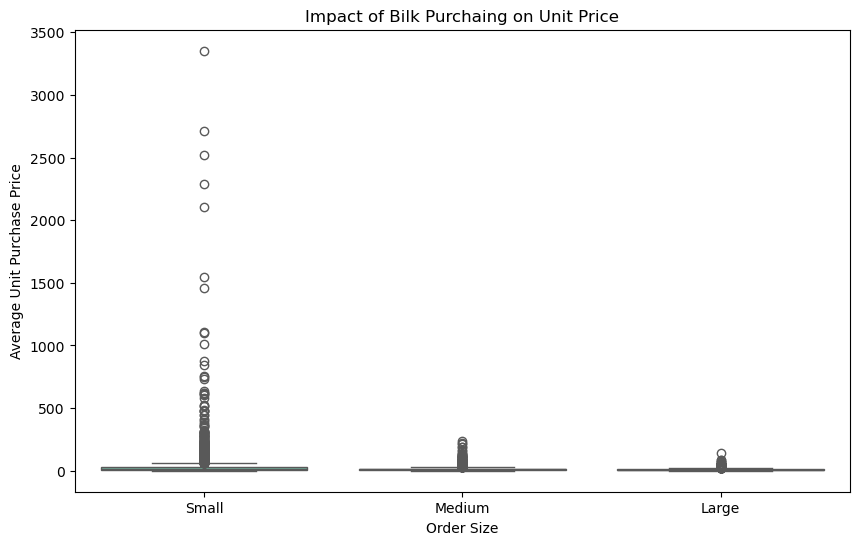

In [32]:
#Box Plot

plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='OrderSize', y='UnitPurchasePrice', palette='Set2')
plt.title("Impact of Bilk Purchaing on Unit Price")
plt.xlabel("Order Size")
plt.ylabel("Average Unit Purchase Price")

plt.show()

## 💡 Pricing Insight

Vendors placing **large orders** receive the **lowest unit price** (\$10.78), a \~72% reduction compared to smaller orders—enabling higher margins if inventory is managed efficiently.
This indicates that **bulk pricing strategies are effective**, driving higher sales volume despite lower per-unit revenue.


**5. Which vendors exhibit low inventory turnover, suggesting excess stock and slow-moving products?**

In [33]:
df[df['StockTurnover']<1].groupby('VendorName')[['StockTurnover']].mean().sort_values('StockTurnover', ascending = True).head(10)

,StockTurnover
VendorName,
ALISA CARR BEVERAGES,0.615385
HIGHLAND WINE MERCHANTS LLC,0.708333
PARK STREET IMPORTS LLC,0.751306
Circa Wines,0.755676
Dunn Wine Brokers,0.766022
CENTEUR IMPORTS LLC,0.773953
SMOKY QUARTZ DISTILLERY LLC,0.783835
TAMWORTH DISTILLING,0.797078
THE IMPORTED GRAPE LLC,0.807569


**6. How much capital is tied up in unsold inventory per vendor, and which vendors contribute the most to this locked capital?**

In [34]:
df['UnsoldInventoryValue'] = (df['TotalPurchaseQuantity'] - df['TotalSalesQuantity']) * df['PurchasePrice']
print('Total Unsold Capital:', format_dollars(df['UnsoldInventoryValue'].sum()))

Total Unsold Capital: 2.71M


In [35]:
# Aggregate Capital lockde per vendor
inventory_value_per_vendor = df.groupby('VendorName')['UnsoldInventoryValue'].sum().reset_index()

# Sort Vendor with Highest Locked Capital
inventory_value_per_vendor = inventory_value_per_vendor.sort_values(by='UnsoldInventoryValue', ascending=False)
inventory_value_per_vendor['UnsoldInventoryValue'] = inventory_value_per_vendor['UnsoldInventoryValue'].apply(format_dollars)
inventory_value_per_vendor.head(10)

,VendorName,UnsoldInventoryValue
25,DIAGEO NORTH AMERICA INC,722.21K
46,JIM BEAM BRANDS COMPANY,554.67K
68,PERNOD RICARD USA,470.63K
116,WILLIAM GRANT & SONS INC,401.96K
30,E & J GALLO WINERY,228.28K
79,SAZERAC CO INC,198.44K
11,BROWN-FORMAN CORP,177.73K
20,CONSTELLATION BRANDS INC,133.62K
61,MOET HENNESSY USA INC,126.48K
77,REMY COINTREAU USA INC,118.60K


**7. What are the 95% confidence intervals for profit margins of both top-performing and low-performing vendors?**

In [36]:
top_threshold = df["TotalSalesDollars"].quantile(0.75)
low_threshold = df["TotalSalesDollars"].quantile(0.25)

In [37]:
top_vendors = df[df['TotalSalesDollars'] >= top_threshold]["ProfitMargin"].dropna()
low_vendors = df[df['TotalSalesDollars'] <= low_threshold]["ProfitMargin"].dropna()

In [38]:
top_vendors

0       25.297693
1       21.062810
2       24.675786
3       27.139908
4       28.412764
          ...    
3523    79.684817
3681    85.782102
4751    93.085860
4920    95.012530
5050    94.271857
Name: ProfitMargin, Length: 2141, dtype: float64

In [39]:
low_vendors

5631     4.111764
5652     6.145626
5701    12.007271
5704     1.677308
5724     7.239599
          ...    
8559    83.448276
8560    96.436186
8561    25.252525
8562    98.974037
8563    99.166079
Name: ProfitMargin, Length: 2141, dtype: float64

In [40]:
def confidence_interval(data, confidence=0.95):
    mean_val = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(len(data))  # Standard Error
    t_critical = stats.t.ppf((1 + confidence) / 2, df=len(data) - 1)
    margin_of_error = t_critical * std_err
    return mean_val, mean_val - margin_of_error, mean_val + margin_of_error

Top Vendors 95% CI: (30.74, 31.61, Mean: 31.18)
Low Vendors 95% CI: (40.50, 42.64, Mean: 41.57)


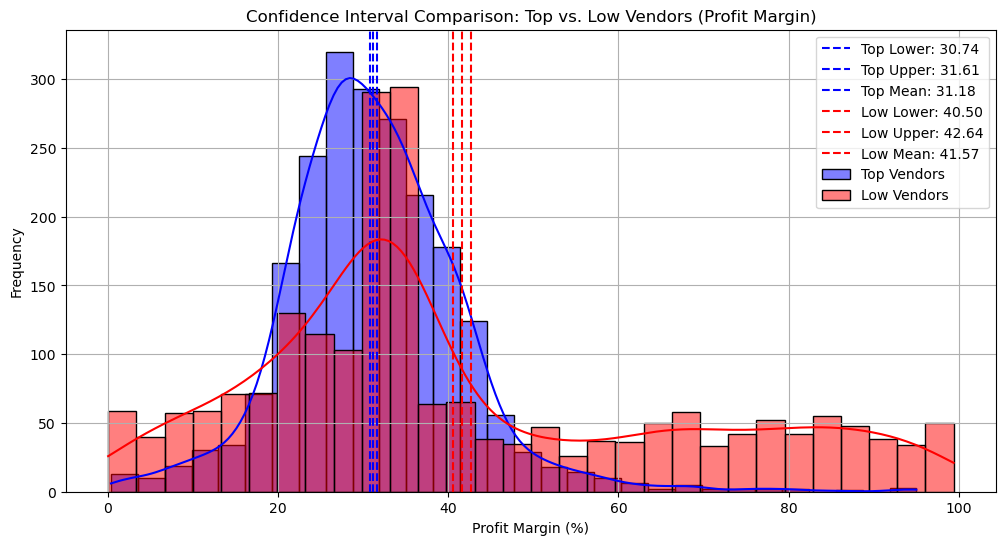

In [41]:
top_mean, top_lower, top_upper = confidence_interval(top_vendors)
low_mean, low_lower, low_upper = confidence_interval(low_vendors)


print(f"Top Vendors 95% CI: ({top_lower:.2f}, {top_upper:.2f}, Mean: {top_mean:.2f})")
print(f"Low Vendors 95% CI: ({low_lower:.2f}, {low_upper:.2f}, Mean: {low_mean:.2f})")

plt.figure(figsize=(12,6))

# Top Vendors Plot
sns.histplot(top_vendors, kde=True, color='blue', bins=30, alpha=0.5, label="Top Vendors")
plt.axvline(top_lower, color='blue', linestyle='--', label=f"Top Lower: {top_lower:.2f}")
plt.axvline(top_upper, color='blue', linestyle='--', label=f"Top Upper: {top_upper:.2f}")
plt.axvline(top_mean, color='blue', linestyle='--', label=f"Top Mean: {top_mean:.2f}")

# Low Vendors Plot
sns.histplot(low_vendors, kde=True, color='red', bins=30, alpha=0.5, label="Low Vendors")
plt.axvline(low_lower, color='red', linestyle='--', label=f"Low Lower: {low_lower:.2f}")
plt.axvline(low_upper, color='red', linestyle='--', label=f"Low Upper: {low_upper:.2f}")
plt.axvline(low_mean, color='red', linestyle='--', label=f"Low Mean: {low_mean:.2f}")

# Finalize Plot
plt.title("Confidence Interval Comparison: Top vs. Low Vendors (Profit Margin)")
plt.xlabel("Profit Margin (%)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

The **95% confidence interval** for **low-performing vendors** (40.50%–42.64%) is significantly higher than that of **top-performing vendors** (30.74%–31.61%). This indicates that vendors with lower sales often maintain higher profit margins—possibly due to premium pricing or leaner operations.

* **Top-performing vendors** could improve profitability through **price optimization**, **cost control**, or **bundling strategies**.
* **Low-performing vendors**, despite high margins, may need better **marketing**, **competitive pricing**, or **enhanced distribution** to boost sales volume.


#### 📊 Is there a significant difference in profit margins between top-performing and low-performing vendors?

**Hypotheses:**

* **H₀ (Null Hypothesis):** There is **no significant difference** in the mean profit margins of top-performing and low-performing vendors.
* **H₁ (Alternative Hypothesis):** The mean profit margins of top-performing and low-performing vendors are **significantly different**.

In [42]:
top_threshold = df["TotalSalesDollars"].quantile(0.75)
low_threshold = df["TotalSalesDollars"].quantile(0.25)

top_vendors = df[df['TotalSalesDollars'] >= top_threshold]["ProfitMargin"].dropna()
low_vendors = df[df['TotalSalesDollars'] <= low_threshold]["ProfitMargin"].dropna()

# Perform Two-Sample T-Test
t_stat, p_value = ttest_ind(top_vendors, low_vendors, equal_var=False)

# Print Results
print(f"T-Statistic: {t_stat:.4f}, P-Value: {p_value:.4f}")
if p_value < 0.05:
    print("Reject H₀: There is a significant difference in profit margins between top and low-performing vendors.")
else:
    print("Fail to Reject H₀: No significant difference in profit margins.")

T-Statistic: -17.6695, P-Value: 0.0000
Reject H₀: There is a significant difference in profit margins between top and low-performing vendors.
